# LMB Python DNN Course Part 1


## Deep Neural Networks Using the Keras Python Module

This course introduces the basics of working with deep neural networks (DNNs) using the [Keras 3](https://keras.io/) and PyTorch Python modules. It is intentional that this course does not go into the detailed mathematics that underpin the function of the DNNs. Rather, the aim of the course is to provide practical experience of working with DNNs using high-level instructions, focusing on a general encoding, training and evaluation pipeline that can be applied in many subject areas.

This course uses two examples, the first relates to the identification of handwritten numerals (a standardized dataset) and a second, more complex example, relating to the classification of biological sequences (proteins in this case). Various simple DNN architectures will be covered, but this course will not cover the 2D convolutional neural networks commonly employed in image analysis; this will be covered by a separate, dedicated course.

To get a feel for how deep neural networks actually work we highly recommend Google Tensorflow's [Neural Network Playground](https://playground.tensorflow.org).  


## The Keras module

Here we make extensive use of the Keras library because it is a fairly simple, high-level means to implement DNNs, that sits on top of an efficient underlying machine-learning framework (here PyTorch). This provides fast computation, running on both a regular computer processor (CPU) or graphics cards (GPU), while at the same time being fairly easy to program for the most commonly used types of DNN.

Installing the Keras Python module so that it works on CPUs is generally straightforward, for example it is easily installed on Linux systems using the `pip install keras` command. However, installing Keras for GPUs can be a little more complex as it involves having the correct hardware drivers and GPU toolkit (low-level API) installed for your graphics card (usually made by NVIDIA). For installing the GPU version, the general procedure is to install an up-to-date [NVIDA graphics driver](https://www.nvidia.com/drivers), and the [CUDA toolkit](https://developer.nvidia.com/cuda-downloads), being careful to make sure that your driver and CUDA versions are compatible. Then you can install the GPU version of [PyTorch](https://pytorch.org/); this is easily achieved on Linux using `pip install torch` (see [here](https://pytorch.org/get-started/locally/) for further help). A final installation of Keras with `pip install keras` should then detect the GPU-enabled libraries.

For the simple DNNs we use in this course the Keras the CPU-only version is generally sufficient and it will make good use of parallel processors. However, the GPU implementation is somewhat faster (caveat to having a modern, compatible graphics card) and makes training much easier in many real-world situations, and especially so with larger DNNs.

### The workflow

This tutorial will spend some time to present various steps that you would implement in a typical DNN workflow. These may be roughly broken down as:

* Preparing main training and test data
* Constructing neural networks
* Training neural networks to minimise loss
* Avoiding over-training
* Optimising and network architecture and parameters
* Objectively assessing predictive performance


<BR CLEAR="left">
<img src="images_ML/03_08.png" style="width: 1000px;" align="left"/>
<BR CLEAR="left">

### Glossary of terms

**Training data**

Training data is the information that is used to update the neural network (via its internal weights that determine the strength of inter-neuron connections) so that it performs some predictive function. For the examples used here, we will be performing supervised machine learning; we have data for which a correct answer is known. Hence, the training data will consist of inputs and the corresponding known, hopefully correct, answer for the outputs. By learning to connect inputs to known outputs the hope is that the network is then sufficiently general to make reliable predictions on unseen data.

**Test data**

Test data refers to data that is used to assess the predictive performance of the network for the purposes of optimising the network architecture and parameters. Test data, just like the main training data, consists of input data paired with the known, correct output data. However, training is separate from the directly used training data; the test data is not used to update DNN weights. However, the test data does influence the formulation of the DNNs predictive model, and so in the strictest sense it cannot be used to test the performance of the network in a completely objective way. 

**Validation data**

Validation data also comprises of inputs paired with known outputs, but has not been used in any way to train the network or optimise it's architecture; it should be completely unseen by the network. Analysis of entirely separate validation data at the end is the only completely fair way to test the predictive performance of the network. During this course we will be lazy and not use properly separate validation data, but this is the wayyou should work for scientific papers.

**Labels**

Labels refer to categorical output data; used by a network for classification purposes. This relates to both the true, known category values that come paired with the training/test data and also the predicted outputs for previously unseen input.

**Array shape**

The shape of an array (coming from the NumPy module) refers to the sizes of the array's independent axes. For linear, 1D arrays this simply means their length. For higher-dimensional arrays, i.e. with more axes, this means the number of rows, columns and layers etc. For example an image array of 512 by 256 pixels with three colour channels (red, green, blue) would have a shape of `(512, 256, 3)`.

**Loss**

Loss represents an error indicating how close a neural network output is to the ideal output, i.e. to the known training data or other objective. This error is quantified using a loss function that is selected to be appropriate to the task at hand, e.g. for categorical output whether only one or multiple outputs can be true/selected.

**Accuracy**

Accuracy represents the proportion of predictions that are, to a certain precision, correct.


## Getting started - Handwriting recognition

Our first practical examples involve recognising handwritten numerals. A selection of these is shown here:

![MNIST examples](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

As you might guess, the task we will require of the DNNs is to take a black-and-white image of a handwritten number and classify it as one of the ten discrete number classes, 0-9. This is an example set that is automatically provided with Keras. These data simplify the task of character recognition by having the training data pre-prepared; the numbers are scaled and centred on to a fixed size pixel grid and have normalised image intensities (going from white to black). In a real-world application you would probably want to use a 2D convolutional network for handwriting recognition as this kind of network is position and (somewhat) scale independent. However, using pre-aligned images means we can provide a tutorial that works with the simplest of neural network architectures.

### Importing modules

The first commands in this notebook perform some set-up for smoother running of the course. These control how the graphical content for graphs and charts will be displayed. Also, certain warnings, which are harmless but would otherwise be distracting are surppressed.

In [15]:
%matplotlib inline

Next we perform some imports to enable access to the NumPy module (which deals with array data) and the MatPlotLib module which will handle the drawing of graphs.

In [16]:
import numpy as np  # Load the NumPy module, assign it the name "np" for convienence
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16,8) # Set plot size

import os
os.environ['KERAS_BACKEND'] = 'torch' # Use PyTorch, rather than Tensorflow under-the-hood in Keras

The last imports relate to the `Keras` library for machine learning. The first line below imports various sub-modules that will be used to construct the DNNs. The second line is the`mnist` example dataset of handwritten digits. And the last import is a handy function to help prepare the input data into a standard form compatible with the network.

In [17]:
from keras import models, layers, regularizers, utils
from keras.datasets import mnist
from keras.utils import to_categorical

Now we actually load the example data and extract the pre-separated training and test data. Then for each of these two sections we separate the input (image) data from the output (numerical categories) data:

In [18]:
train, test = mnist.load_data()
train_images_2d, train_labels = train
test_images_2d, test_labels = test

We can inspect the contents of the dataset using the `.imshow()` function of MatPlotLib. These data are greyscale images if 28 by 28 pixels, which corresponds to a total of 784 separate (though often correlated) input features.

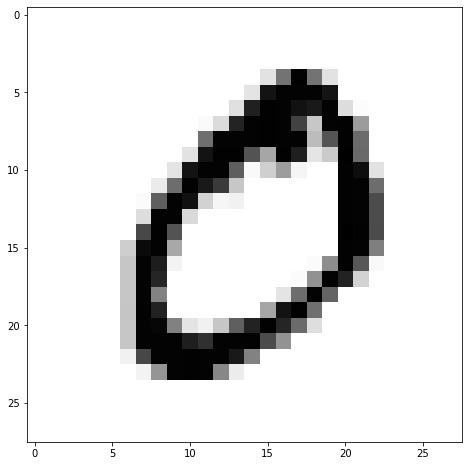

In [19]:
from matplotlib import pyplot as plt

plt.imshow(train_images_2d[1], cmap='Greys')
plt.show()

Before we can use these data they must be adapted to work with a DNN that expects a 1D input vector and the input and output values to be floating point numbers in the range 0.0 to 1.0 (or sometimes -1.0 to 1.0), or at least approximately so.

Hence, to prepare the input data we change the shapes of the data arrays to convert what is effectively a list of image matrices (each with rows and columns) into a list of flat, 1D vectors. The DNNs we use will sill be able to detect correlations between the pixels even if the data is rearranged because we well be using a fully connected network (as long as the same arrangement is preserved for all input data).

In [20]:
print(train_images_2d.shape)
print(test_images_2d.shape)
n_train, w, h = train_images_2d.shape
n_test, w, h = test_images_2d.shape

(60000, 28, 28)
(10000, 28, 28)


Hence, the last two axes are combined into one:

In [21]:
size = w * h
train_images = train_images_2d.reshape(n_train, size)
test_images  = test_images_2d.reshape(n_test, size)
print(train_images.shape)
print(test_images.shape)
print(train_images.min(), train_images.max())

(60000, 784)
(10000, 784)
0 255


The input image data is then scaled so that the pixel intensity values, which are initially in the range 0 to 255, are put into the range 0.0 to 1.0, i.e. to work at a scale that the DNNs are tuned to.

In [22]:
print(train_images.min(), train_images.max())

train_images = train_images.astype(float)/255.0
test_images  = test_images.astype(float)/255.0

print(train_images.min(), train_images.max())

0 255
0.0 1.0


The output data must also be prepared for use with the network. As we can see, these are a flat 1D array containing the numbers 0-9; i.e. labels representing number categories:

In [23]:
print(train_labels.shape)
print(train_labels[:10])

(60000,)
[5 0 4 1 9 2 1 3 1 4]


However, we want the output data to be in the range 0.0 to 1.0 (not 0 to 9). You might be tempted to simply scale the number labels. However, this will not work well, because we are dealing with discrete categories; the labels are separate and the "0" numeral is not closest to "1" in the handwriting sense.

Instead what we do is convert the number categories into a binary matrix. Each output will be a length 10 vector full of mostly `0.0` with a `1.0` in one column indicating which (number) category is selected. Our output data is easily converted into this form using the `to_categorical()` function from Keras.

In [24]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print(train_labels.shape)
print(train_labels[:10])

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


### Adding fully-connected neural network layers

At last we come to a point where we actually start to construct a neural network. We will begin by constructing a somewhat old-fashioned three-layer feed-forward neural network. Firstly we construct the neural network framework using the "Sequential" model provided by Keras: this is an easy means for successively adding the networks layers, each of which is connected to the previous layer. The other "functional" way of constructing the NN allows more complex interconnections, but we will not need that here.

In [25]:
nn1 = models.Sequential()
layer = layers.Input([size])
nn1.add(layer)
print(nn1.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Once the framework for our first neural network `nn1` is initialised, we can then add its first layer. The first layer is a `Dense` layer, which means it is a fully connected one; all inputs connect to all nodes:
This is the layer that will accept the flattened image data.

We specify that the layer should have a specified number of neuron nodes (here `32`) and that it should expect input of length `size` (which came from image width times height). The `activation` parameter is set to `relu` ([rectified linear unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)). Setting the activation means we are specifying how the neural nodes respond to the sum of their input weights. The `relu` option generates a linear response if positive and none when negative. This type of activation function is very commonly used with DNNs and enables better training of deep networks.

In [26]:

layer = layers.Dense(32, activation='relu')
nn1.add(layer)
print(nn1.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 32)             │        25,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,120 (98.12 KB)

 Trainable params: 25,120 (98.12 KB)

 Non-trainable params: 0 (0.00 B)

None


We then add a second, output layer. Here we do not need to specify the data shape, as Keras can deduce this from the number of nodes in the previous layer. The layer has `10` nodes: one for each category of output. The `softmax` activation here is commonly used for binary categorical output (where one number should be 1.0 and the rest 0.0); it is a scaled exponential that acts as a sensitive trigger for positive values.

In [27]:
nn1.add(layers.Dense(10, activation='softmax'))

The object representing the neural network has a handy `.summary()` function that described the construction of its various layers.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,450 (99.41 KB)

 Trainable params: 25,450 (99.41 KB)

 Non-trainable params: 0 (0.00 B)

None


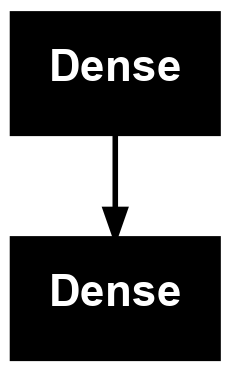

In [28]:
print(nn1.summary())
utils.plot_model(nn1)

It should be noted that the size of the input vector is `784` fixed (by the size of the image) and that the size of the output, `10` is fixed by the number of categories. Also, the number of nodes diminishes between these two values (`256` then `32`): this funnels the decision-making nodes into fewer states. Setting an optimal number of nodes can be achieved by trying different values and seeing which work best. When tweaking the parameters in this way it can be quickly established that, beyond a certain number, adding more nodes does not improve training and slows things down. Having fewer nodes will improve speed, but too few will degrade predictive performance.

Lastly we finalize the network's construction using the `.compile()` function. Here we are specifying three options. The first, `optimiser` specifies which method (from a standard set) will be used to improve the network weights during training. The `loss` option states how we score comparisons between the network's generated output and the actual known training output. This is generally set according to the type of output. Here `'categorical_crossentropy'` is the standard choice for categorical selection where only one category can be correct. The last `metrics` option simply specifies which parameters we would like to follow during the training procedure.

In [29]:
nn1.compile(optimizer='rmsprop', loss='categorical_crossentropy',
            metrics=['accuracy'])

### Loss functions

There are many different loss functions that are availabe in Keras. Athough you are fairly free to try different ones, each is created for a particular kind of output and often works best with a specific activation function being present in the last layer.

Some of the available loss functions include:

* `binary_crossentropy` : this is used when is a single true/false output *or* if there are multiple true/false outputs where multiple outputs can be true at once. This is usually paired with a *sigmoidal* activation function in the output layer.

* `categorical_crossentropy` : this is used for selecting one amongst multiple categorical classes, i.e. where only one output can be true. There should be an output node for each class. This is usually paired with a *softmax* output layer activation function.

* `mean_squared_error` : this is often the first choice for regression problems. This can be used with a *linear* activation function if the range of outputs is unbounded or a *sigmoidal* activation function if bounded.

### Training 

Next we actually strain the netral network `nn1` by using the `.fit()` function on the training input and (correct) target training output. Here `epochs` relates to the number of repeat training iterations, over the whole training dataset and `batch_size` states how many input examples to sample each time the network is updated. The validation data is naturally the test input and test output.

In [30]:
history = nn1.fit(train_images, train_labels, epochs=10, batch_size=1024,
                 validation_data=(test_images, test_labels))

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5824 - loss: 1.4945 - val_accuracy: 0.8801 - val_loss: 0.5163
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8833 - loss: 0.4676 - val_accuracy: 0.9049 - val_loss: 0.3441
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9087 - loss: 0.3305 - val_accuracy: 0.9211 - val_loss: 0.2843
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9208 - loss: 0.2843 - val_accuracy: 0.9288 - val_loss: 0.2563
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9288 - loss: 0.2539 - val_accuracy: 0.9319 - val_loss: 0.2374
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9334 - loss: 0.2367 - val_accuracy: 0.9364 - val_loss: 0.2230
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9380 - loss: 0.2188 - val_accuracy: 0.9389 - val_loss: 0.2082
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9422 - loss: 0.2054 - val_accuracy: 0.9400 - val_loss:

Note how the function call above captures `history` which records the accuracy values etc. during the training procedure. (We will inspect this later on)

Although the training produces textual output to indicate how accurate the predictions are. The network can be evaluated at any time, using any paired input and output data, via the `.evaluate()` function.

In [31]:
test_loss, test_acc = nn1.evaluate(test_images, test_labels)

msg = 'Acc: {:.2f}%'.format(test_acc*100.0)
print(msg)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9370 - loss: 0.2105
Acc: 94.61%


Hopefully you will see an accuracy of around 94-95%, which is pretty good considering that out network only has two fairly narrow layers.

With the trained network we can also, obviously, use it to make predictions. Here we extract and display a random image from the test data.

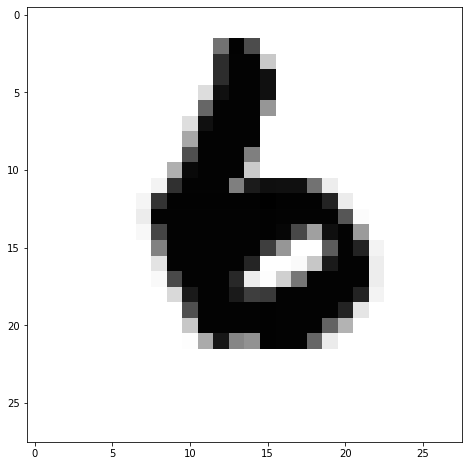

In [32]:
from random import randint
idx = randint(0, len(test_images))
img = test_images[idx]
plt.imshow(img.reshape(w,h), cmap='Greys')
plt.show()

Then we can run the tet data through the neural network with the `.predict()` function and see what the prediction for this image is. Note that the network output is categorical binary: a length ten vector where only one value will be near one, the rest zero. Hence, to extract the digit class we find the index of the maximum (i.e. selected) value with NumPy's `.argmax()`.

In [ ]:
out = nn1.predict(test_images)
print('Binary out:', np.round(out[idx], 3))
print('Digit out:', np.argmax(out[idx]))

Next we return to the history data that we recorded when the neural network was trained. 

So that we can easily inspect the training history, a helper function `plot_training_histroy()` is provided below. This will take any number of history objects and plot graphs for how the loss (the mismatch between predictions and training output) and the accuraccy change during changing, for both the main training data and the test data (which was nut directly trained with).

In [ ]:
from matplotlib import cm

def plot_training_history(*histories):
    cmap = plt.get_cmap('tab10')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plot_options = {'linewidth':2, 'alpha':0.8} # A dictionary of inputs for all charts
    
    for i, history in enumerate(histories):
        hd = history.history
        n = np.arange(len(hd['loss'])) + 1
        plot_options['color'] = cmap(float(i % 10)/10)
        
        ax1.plot(n, hd['loss'], label='Train %d' % i,
                 linestyle='--', **plot_options)
        ax1.plot(n, hd['val_loss'], label='Test %d' % i,
                 **plot_options)
        ax1.set_title('Loss')
        
        ax2.plot(n, hd['accuracy'], label='Train %d' % i,
                 linestyle='--', **plot_options)
        ax2.plot(n, hd['val_accuracy'], label='Test %d' % i,
                 **plot_options)
        ax2.set_title('Accuracy')
        
    ax1.legend()    
    ax2.legend()
    plt.show()

The history plotting function is then run on the `history` object generated earlier. You can see that the loss is reduced as the accuraccy increases, for both segments of data. Though the accuracy levels of at about 97-98% the training could be run for longer (e.g. more epochs) to get a slight improvement. However, while training for longer increases the accuracy for the training data it plateaus earlier for the test data. This is an indication that the network is becoming **over trained**, i.e. too specialised to the traiing data, and so lo longer general enough to give the same accuracy on unseen data. 

In [ ]:
plot_training_history(history)

### Adding layers

Expanding upon this first network, we can see what happens if we introduce more layers. Construction is similar to before, albeit now with three layers.

In [ ]:
nn1 = models.Sequential()
nn1.add(layers.Input([size]))
nn1.add(layers.Dense(256, activation='relu')) # New, wider input layer
nn1.add(layers.Dense(32, activation='relu'))                      # Middle layer
nn1.add(layers.Dense(10, activation='softmax'))
nn1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
nn1.summary()

history1 = nn1.fit(train_images, train_labels, epochs=10, batch_size=1024,
                 validation_data=(test_images, test_labels))

With the three-layer network we get even better predictive performance

In [ ]:
plot_training_history(history, history1)

### Layer widths

Next we look at what happens when the number of nodes in the network layers are adjusted. Here we create a similar network and try using double the number of nodes in the middle layer.

In [ ]:
nn2 = models.Sequential()
nn2.add(layers.Input([size]))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(64, activation='relu')) # Initially 32
nn2.add(layers.Dense(10, activation='softmax'))
nn2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
nn2.summary()

In [ ]:
history2 = nn2.fit(train_images, train_labels, epochs=10, batch_size=1024,
                 validation_data=(test_images, test_labels))

Comparison of the history objects shows that although the loss minimisation is generally slightly better for the training data there is no real improvement in the accuracy of the test data.

In [ ]:
plot_training_history(history1, history2)

Running with far fewer nodes trains faster, as we might expect, but shows a decrease in the training accuracy. Indeed this is not much better than the intial two-layer network.

In [ ]:
nn2 = models.Sequential()
nn2.add(layers.Input([size]))
nn2.add(layers.Dense(32, activation='relu')) # Was 256
nn2.add(layers.Dense(32, activation='relu'))
nn2.add(layers.Dense(10, activation='softmax'))
nn2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
nn2.summary()

In [ ]:
history2 = nn2.fit(train_images, train_labels, epochs=10, batch_size=1024,
                 validation_data=(test_images, test_labels))

plot_training_history(history1, history2)

### Over-training

We will now run the first three-layer network again for more iterations (`epochs=20`) to better show the overtraining in the network; as the loss and accuracy for the training data diverges from the test data.

In [ ]:
nn1 = models.Sequential()
nn1.add(layers.Input([size]))
nn1.add(layers.Dense(256, activation='relu'))
nn1.add(layers.Dense(32, activation='relu'))
nn1.add(layers.Dense(10, activation='softmax'))
nn1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history1 = nn1.fit(train_images, train_labels, epochs=20, batch_size=1024,
                 validation_data=(test_images, test_labels))

In later iterations (epoch > 10) there is a clear divergence in both the loss and accuracy of the test and compare to the training data. Also, we can see that the results for the test data are more noisy than the training data. Hence, in essence out network has become too specialised toward the training data and loses predictive performance on unseen data.

In [ ]:
plot_training_history(history1)

### Going  deep

It may be tempting to improve the network by opting for a deeper architecture, with more layers. However, the deeper the network the more the capacity for overtraining and the slower and more difficult the training. Here for example, having three fairly wide internal layers does not improve predictions and indeed makes the overtraining slightly worse:

In [ ]:
nn2 = models.Sequential()
nn2.add(layers.Input([size]))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(128, activation='relu'))
nn2.add(layers.Dense(128, activation='relu'))
nn2.add(layers.Dense(128, activation='relu'))
nn2.add(layers.Dense(10, activation='softmax'))
nn2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
nn2.summary()

In [ ]:
history2 = nn2.fit(train_images, train_labels, epochs=20, batch_size=1024,
                   validation_data=(test_images, test_labels))

In [ ]:
plot_training_history(history1, history2)

### Activations

As is hopefully becoming obvious, there are a vast number of tweaks that can be made to the DNN architecture. However, it shouldn't take too long to see what is to complex or too simple as long as we take care to analyse the training history. Similarly, we can test the other high-level parameters. For example here we test the 'sigmoid' activation function: historically this was often the favoured option for three-layer networks before training deep networks became practical.

As we can see this activation function trains the DNN somewhat more slowly than `relu`, and in the end (if we train for further iterations) has a worse accuracy. Interestingly, however, the overtraining is less severe; this is probably because the sigmoidal function can attenuate large weights.

In [ ]:
nn3 = models.Sequential()
nn3.add(layers.Input([size]))
nn3.add(layers.Dense(256, activation='sigmoid'))
nn3.add(layers.Dense(32, activation='sigmoid'))
nn3.add(layers.Dense(10, activation='softmax'))
nn3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history3 = nn3.fit(train_images, train_labels, epochs=20, batch_size=1048,
                   validation_data=(test_images, test_labels))

In [ ]:
plot_training_history(history2, history3)

### Optimisers

We can also play with different training optimisers: the routines which adjust the network weights (in a back-propagation manner) according to internal gradients. When choosing an optimiser we not only have to think about the prediction accuracy, but also the convergence efficiency and the stability; sometimes the DNN weights can bounce around rather than converge smoothly. Here we test the `adam` optimiser and show that it works fairly well with fast convergence and good accuracy. Indeed, this is often a good intial one to try for many fully-connected DNNs.

In [ ]:
nn3 = models.Sequential()
nn3.add(layers.Input([size]))
nn3.add(layers.Dense(256, activation='relu'))
nn3.add(layers.Dense(32, activation='relu'))
nn3.add(layers.Dense(10, activation='softmax'))

opt = 'adam' #'sgd' is bad
nn3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history3 = nn3.fit(train_images, train_labels, epochs=20, batch_size=1048,
                   validation_data=(test_images, test_labels))

With this new optimiser we can see that training has become a bit more efficient and a little smoother. There is a perhaps a small improvement in accuracy, but overtraining is still evident. 

In [ ]:
plot_training_history(history2, history3)

### Regularisation

One way of reducing over-training is to add a regulariser to the layers. This encourages the network to adopt a more general set of internal weights by penalising weights from becoming too large; large weights are an indication of specialisation to specific inputs. Here we add an 'L2' regulariser which penalises based on the square of the weight.

In [ ]:
reg = regularizers.l2(0.001)

nn4 = models.Sequential()
nn4.add(layers.Input([size]))
nn4.add(layers.Dense(256, activation='relu', kernel_regularizer=reg))
nn4.add(layers.Dense(32, activation='relu', kernel_regularizer=reg))
nn4.add(layers.Dense(10, activation='softmax'))
nn4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn4.summary()

history4 = nn4.fit(train_images, train_labels, epochs=20, batch_size=1024,
                   validation_data=(test_images, test_labels))

As we can see this does help with overtraining and doesn't affect test accuracy much (if we can train for longer).

In [ ]:
plot_training_history(history3, history4)

### Dropout

A generally better way to avoid overtraining is by using a technique called *dropout*. What this does is to temporarily remove a random selection of weights (and hence input nodes) from the networks inter-layer connections. This prevents the weights becoming too specialised toward the training data; as random connections in the network are omitted the remaining connections are forced toward sparser, more general/average solutions with less co-dependency between particular nodes. 

Within Keras this is simply achieved by adding extra `Dropout` layers, and for each specifying the proportion of input connections to randomly omit (values from 0.2 to 0.4 is generally a good starting point). As we can see, this technique slows training but removes the over-training and maintains a good test accuracy. Indeed, the network may be a little under-trained (so we could train for longer).

In [ ]:
nn4 = models.Sequential()
nn4.add(layers.Input([size]))
nn4.add(layers.Dense(256, activation='relu'))
nn4.add(layers.Dropout(0.4))
nn4.add(layers.Dense(32, activation='relu'))
nn4.add(layers.Dropout(0.4))
nn4.add(layers.Dense(10, activation='softmax'))
nn4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn4.summary()

In [ ]:
history4 = nn4.fit(train_images, train_labels, epochs=40, batch_size=1024,
                   validation_data=(test_images, test_labels))

plot_training_history(history3, history4)


++ Add noise


In [ ]:
nn4a = models.Sequential()
nn4a.add(layers.Input([size]))
nn4a.add(layers.GaussianNoise(stddev=0.5))
nn4a.add(layers.Dense(256, activation='relu'))
nn4a.add(layers.Dense(32, activation='relu'))
nn4a.add(layers.Dense(10, activation='softmax'))
nn4a.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn4a.summary()

In [ ]:
history4a = nn4a.fit(train_images, train_labels, epochs=40, batch_size=1024,
                   validation_data=(test_images, test_labels))

In [ ]:
plot_training_history(history4, history4a)

### Outlier analysis

After making a variety of tweaks that improve the DNN accuracy and reduce overtraining we are consistently reaching a test set accuracy of around 98%. We may be fairly satisfied with the result. However, we may learn something if we investigate the images for which we still cannot make good predictions.

In [ ]:
loss, acc = nn4.evaluate(test_images, test_labels)
print('Loss: {:.3f} Accuracy:{:.3f}'.format(loss, acc))

To do this we need to find the images where the DNN output prediction has a mismatch to the known labels. We can do this by converting the binary, categorical arrays to the index of the highest-scoring/largest value and test whether these are the same or different:

In [ ]:
out_pred = nn4.predict(test_images)
out_nums = out_pred.argmax(axis=1)
known_nums = test_labels.argmax(axis=1)
print(out_nums[:10])
print(known_nums[:10])

Testing whether the outputs differ involves the `!=` test (not equals), so we can pull out the indices where they are indeed different using NumPy's `.nonzero()`:

In [ ]:
known_nums = test_labels.argmax(axis=1)
different = out_nums != known_nums
bad = different.nonzero()[0]  # Indices of True values: where arrays are different
print(bad)

We can then inspect some of the images where the known and predicted digit differ. To the human eye, some of these errors might be deemed understandable, but we might to improve others by adjusting the DNN (perhaps moving to a convolutional architecture).

In [ ]:
n = 10 # Limit to first five errors
indices = bad[:n] 
fig, axarr = plt.subplots(1, n) # n columns of images

for a, idx in enumerate(indices):
    img = test_images[idx,:].reshape(w,h)
    p = out_nums[idx]
    k = known_nums[idx]
    axarr[a].imshow(img, cmap='Greys')
    axarr[a].set_title('Pred: {} True: {}'.format(p, k))
    
plt.show()

## Convolutional layers

In [ ]:
from keras.optimizers import Adam

nn5 = models.Sequential()

nn5.add(layers.Input([w, h]))
nn5.add(layers.GaussianNoise(stddev=0.5))
nn5.add(layers.Reshape([w, h, 1]))
nn5.add(layers.Dropout(0.1))
conv2d = layers.Conv2D(10, 28, activation='softmax')
nn5.add(conv2d)
nn5.add(layers.Flatten())

nn5.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
nn5.summary()

In [ ]:
nn5.fit(train_images_2d, train_labels, epochs=10, batch_size=32,
        validation_data=(test_images_2d, test_labels))

In [ ]:
weights = conv2d.get_weights()[0]
print(weights.shape)

In [ ]:

def plot_conv_weights(weights, ncols=5):
    k1, k2, depth, features = weights.shape
    nrows = features // ncols
    fig, axes = plt.subplots(nrows, ncols)
    for i in range(nrows*ncols):
        ax = axes[i // ncols, i % ncols]
        ax.imshow(weights[:,:,0,i], cmap='RdBu')
        ax.set_title(f'{i}', fontsize=20)

    plt.show()
    
plot_conv_weights(weights)    
    

In [ ]:
nn6 = models.Sequential()

nn6.add(layers.Input([w, h]))
nn6.add(layers.Reshape([w, h, 1]))
nn6.add(layers.GaussianNoise(stddev=0.5))

conv2d = layers.Conv2D(16, 7, activation='relu')
nn6.add(conv2d)
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Flatten())

nn6.add(layers.Dense(10, activation='softmax'))

nn6.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
nn6.summary()

In [ ]:
history6 = nn6.fit(train_images_2d, train_labels, epochs=10, batch_size=32,
                   validation_data=(test_images_2d, test_labels))

plot_training_history(history4, history6)

In [ ]:
weights6 = conv2d.get_weights()[0]
plot_conv_weights(weights6, 4)

In [ ]:
nn7 = models.Sequential()

nn7.add(layers.Input([w, h]))
nn7.add(layers.Reshape([w, h, 1]))
nn7.add(layers.GaussianNoise(stddev=0.5))

nn7.add(layers.Conv2D(16, 7, activation='relu'))
nn7.add(layers.Dropout(0.2))

nn7.add(layers.Conv2D(16, 5, activation='relu', strides=2))
nn7.add(layers.Dropout(0.2))
nn7.add(layers.Flatten())

nn7.add(layers.Dense(10, activation='softmax'))

nn7.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
nn7.summary()

In [ ]:
history7 = nn7.fit(train_images_2d, train_labels, epochs=10, batch_size=32,
                   validation_data=(test_images_2d, test_labels))

plot_training_history(history6, history7)

Synthetic data

Pretraining

Autoencoder for denoising

